# Does having an unlimited dimension affect NetCDF throughput?

tl;dr No. See below for details.

In [10]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

sys.path.append('../util')
from meters import ThroughputMeter
import ncgen

import netCDF4
import numpy as np
import pylab as pl

os.environ['TMPDIR'] = os.getenv('HOME') + '/tmp/'

In [3]:
results = []
for unlim in [True, False]:
    for num_vars in range(1, 20):
        print("Creating a NetCDF file with {} {}limited variables".format(num_vars, 'un' if unlim else ''))
        with NamedTemporaryFile(suffix='.nc', delete=False) as f:
            nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=True)
            nc.close()
        nc = netCDF4.Dataset(f.name, 'r')
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:, :, :]
        print(t.megabytes_per_second(a))
        
        # python-netCDF4 seems to leak file descriptors
        # We have to take a lot of steps to make sure that the files get closed and that
        # the space gets reclaimed by the OS
        nc.close
        del nc
        print("Removing {}".format(f.name))
        os.remove(f.name)
        f.close()
        collect()
        results.append((unlim, num_vars, t.megabytes_per_second(a)))


Creating a NetCDF file with 1 unlimited variables
0
353.100 MB in 0.556 seconds at 635.390 MB / sec
635.390136615
Removing /home/james/tmp/tmp2uhtnl.nc
353.100 MB in 0.556 seconds at 635.390 MB / sec
Creating a NetCDF file with 2 unlimited variables
0
353.100 MB in 0.571 seconds at 618.126 MB / sec
618.125623705
Removing /home/james/tmp/tmpdtht2u.nc
353.100 MB in 0.571 seconds at 618.126 MB / sec
Creating a NetCDF file with 3 unlimited variables
0
353.100 MB in 0.585 seconds at 603.195 MB / sec
603.195314568
Removing /home/james/tmp/tmpv40by_.nc
353.100 MB in 0.585 seconds at 603.195 MB / sec
Creating a NetCDF file with 4 unlimited variables
0
353.100 MB in 0.582 seconds at 606.208 MB / sec
606.208493753
Removing /home/james/tmp/tmp_h16wh.nc
353.100 MB in 0.582 seconds at 606.208 MB / sec
Creating a NetCDF file with 5 unlimited variables
0
353.100 MB in 3.17 seconds at 111.374 MB / sec
111.374210298
Removing /home/james/tmp/tmp94z87o.nc
353.100 MB in 3.17 seconds at 111.374 MB / sec
Cr

In [4]:
results

[(True, 1, 635.39013661463582),
 (True, 2, 618.12562370485375),
 (True, 3, 603.19531456825518),
 (True, 4, 606.20849375334114),
 (True, 5, 111.3742102979798),
 (True, 6, 95.13927202437506),
 (True, 7, 94.041127835165582),
 (True, 8, 92.340051116604513),
 (True, 9, 96.179426666961064),
 (True, 10, 94.010623718984661),
 (True, 11, 95.849563660135573),
 (True, 12, 92.296453989106453),
 (True, 13, 99.634513358459586),
 (True, 14, 96.800871922494323),
 (True, 15, 108.05263632895436),
 (True, 16, 98.464994871003185),
 (True, 17, 104.22698201470669),
 (True, 18, 91.828060035535614),
 (True, 19, 111.95060833250058),
 (False, 1, 646.95524542241026),
 (False, 2, 646.13078651744217),
 (False, 3, 653.10745306116689),
 (False, 4, 654.78973881933291),
 (False, 5, 650.86607826790498),
 (False, 6, 105.40790842923852),
 (False, 7, 93.76462991613711),
 (False, 8, 92.491799122050466),
 (False, 9, 101.46517172192735),
 (False, 10, 91.646597131110667),
 (False, 11, 90.990524314777488),
 (False, 12, 101.855

In [13]:
a = np.array([result[2] for result in results])

In [14]:
a = a.reshape((2, 19))

In [17]:
%matplotlib inline

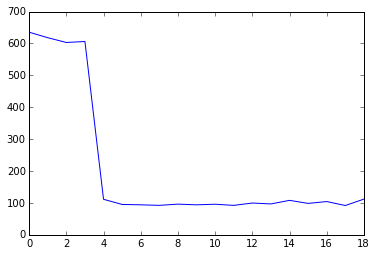

In [19]:
pl.plot(a[0,:])

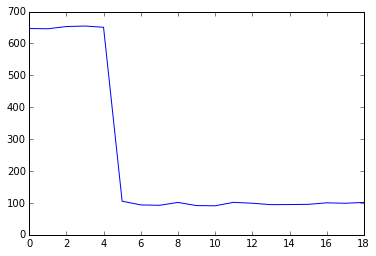

In [20]:
pl.plot(a[1,:])

There seems to be some threshold at 4 to 5 variables. Maybe that's the size at which it cannot be cached in memory?

In [26]:
353.100 * np.arange(4, 7)

array([ 1412.4,  1765.5,  2118.6])

In [28]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7945       5795       2150       2295        165       3206
-/+ buffers/cache:       2423       5521
Swap:        47685        640      47044


I presently have 2150 MB free on the system, so it's pretty plausible that 6 variables at 2100 MB pushes me out of cache on to disk. That explains the jump. But, the morale of the story here is that there is *no* distinguishable difference between the throughput of unlimited and limited variables.

In [29]:
!hostname

basalt
